# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [1]:
# Harry Potter -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-11 12:40:56--  https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip [following]
--2023-12-11 12:40:56--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/harry/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17592727 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  16.78M  --.-KB/s    in 0.1s    

2023-12-11 12:40:56 (146 MB/s) - ‘data.zip’ saved [17592727/17592727]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [2]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [3]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        class_name = member.find('name').text
        class_id = class_dict[class_name]
        res = (xmin, ymin, xmax, ymax, class_id)
        bboxes.append(res)

    return bboxes

In [4]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = Image.open(fname)
        image = np.array(image)

        bboxes = self.__get_raw_item__(idx)[1]

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [6]:
train_ds = PascalDataset(root="data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize(images, bboxes, class_dict_inv):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100)

    for i, ax in enumerate(axes.reshape(-1)):
        ax.axis(False)

        if i >= len(images):
            break

        image = images[i].permute(1, 2, 0).numpy() * std + mean
        image = np.clip(image, 0, 1)

        ax.imshow(image)

        for bbox in bboxes[i]:
            label = class_dict_inv[bbox[4]]
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], label, fontsize=8, color='r', verticalalignment='top')

    fig.tight_layout()
    plt.show()

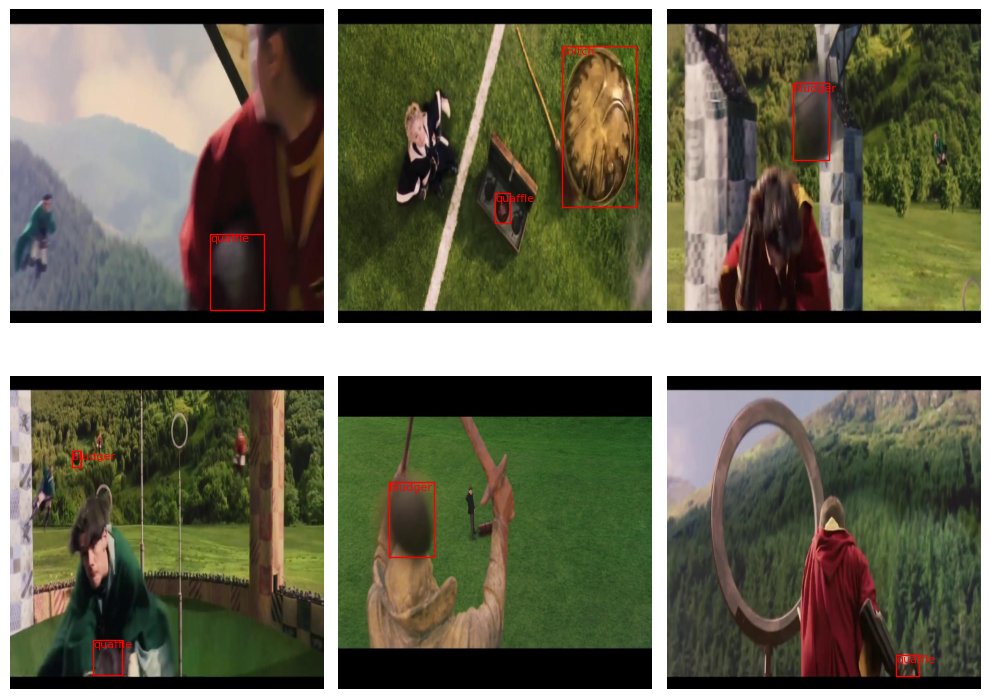

In [8]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out], train_ds.class_dict_inv)

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [9]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  downsample # TODO размер клетки по X в пикс
        y_cell =  downsample # TODO размер клетки по Y в пикс
        w_box =  (xmax - xmin) / w# TODO ширина бокса отнормированная
        h_box =  (ymax - ymin) / h# TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2# TODO (координаты центра в исходных координатах)
        cy =  (ymax + ymin) / 2# TODO
        cx_idx =  cx // x_cell# TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx =  cy // y_cell# TODO
        cx_idx= cx_idx.to(torch.int)
        cy_idx = cy_idx.to(torch.int)

        cx_box =  (cx / x_cell) - cx_idx# TODO (посчитайте сдивиги относительно cx_idx)
        cy_box =  (cy / y_cell) - cy_idx# TODO

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

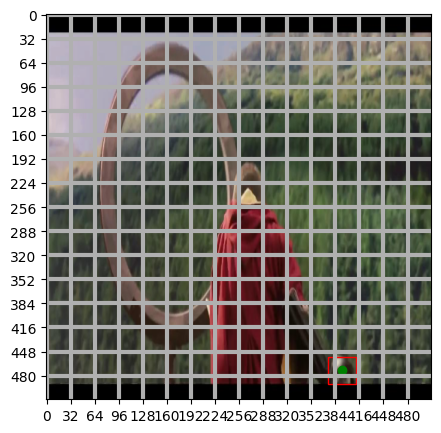

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 5

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [11]:
W, H = 512, 512
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    if h > 6:
        class_preds = pred[:, 5:, :, :]
        class_preds = torch.argmax(class_preds, dim=1, keepdim=True)
        pred = torch.cat([pred[:, :5, :, :], class_preds], dim=1)

    batch_boxes = []
    for batch in range(b):
        img_boxes = []
        for i_h in range(h):
            for i_w in range(w):
                prediction_pixel = np.array(pred[batch, :, i_h, i_w])
                prob = prediction_pixel[4]
                if (prob < threshold):
                    continue
                [cx_box, cy_box, w_box, h_box] = prediction_pixel[:4]

                c_x = (i_w + cx_box) * upsample
                c_y = (i_h + cy_box) * upsample

                w_box *= W
                h_box *= H

                xmax = c_x + w_box / 2
                xmin = c_x - w_box / 2
                ymax = c_y + h_box / 2
                ymin = c_y - h_box / 2

                class_of_item = prediction_pixel[5]
                img_boxes.append((xmin, ymin, xmax, ymax, class_of_item))

        batch_boxes.append(img_boxes)
    return batch_boxes

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [12]:

class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        C = 3
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.model = nn.Sequential(*list(model.children())[:-3])

        self.conv1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(512, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(128, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(16, 5+C, kernel_size=2, stride=2)
        self.sigmoid = nn.Sigmoid()
        ### YOUR CODE HERE ###

    def forward(self, x):
        x = self.model(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [13]:
import torch
import torch.nn.functional as F

def special_loss(pred, target, check=False, C=3):
    target = target.permute(0, 2, 3, 1)
    pred = pred.permute(0, 2, 3, 1)
    mask = target[..., 4] > 0
    un_mask = target[..., 4] == 0
    masked_pred = pred[mask]
    masked_target = target[mask]
    masked_unpred = pred[un_mask]
    masked_un_target = target[un_mask]

    localization_loss = F.mse_loss(masked_pred[..., :2], masked_target[..., :2], reduction='sum')
    box_loss = F.mse_loss(torch.sqrt(masked_pred[..., 2:4]), torch.sqrt(masked_target[..., 2:4]), reduction='sum')
    classification_loss = F.cross_entropy(masked_pred[..., 5:], masked_target[..., 5].long(), reduction='sum')

    object_confidence_loss = F.binary_cross_entropy(masked_pred[..., 4], masked_target[..., 4], reduction='sum')
    no_object_confidence_loss = F.binary_cross_entropy(masked_unpred[..., 4], masked_un_target[..., 4], reduction='sum')

    confidence_loss = object_confidence_loss + 0.1 * no_object_confidence_loss

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [14]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [15]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 30
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=5e-5)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    cur_epoch_loss = 0
    for batch in pbar:
        image = batch['image'].to(device)
        target = batch['target'].to(device)
        pred = model(image)
        loss = special_loss(pred, target)

        cur_epoch_loss += np.array(loss.cpu().detach())
        loss.backward()
        opt.step()

    epoch_losses.append(cur_epoch_loss / len(pbar))


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 107MB/s]


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 0 done; Train loss 195.112;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1 done; Train loss 147.629;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2 done; Train loss 128.182;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3 done; Train loss 111.661;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4 done; Train loss 94.563;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5 done; Train loss 81.885;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6 done; Train loss 74.848;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7 done; Train loss 67.106;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8 done; Train loss 60.272;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9 done; Train loss 56.180;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10 done; Train loss 50.092;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11 done; Train loss 46.192;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12 done; Train loss 43.847;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13 done; Train loss 39.365;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14 done; Train loss 37.130;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15 done; Train loss 36.314;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16 done; Train loss 33.931;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17 done; Train loss 31.481;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18 done; Train loss 30.376;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19 done; Train loss 29.544;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20 done; Train loss 28.072;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 21 done; Train loss 27.190;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22 done; Train loss 25.530;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23 done; Train loss 24.358;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24 done; Train loss 23.826;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25 done; Train loss 22.772;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 26 done; Train loss 21.447;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 27 done; Train loss 20.713;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 28 done; Train loss 19.967;


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 29 done; Train loss 19.019;


Запустим обученный детектор на тестовых изображениях:

In [17]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [18]:
# Нужно сделать предсказание и переложить результат на cpu

image = batch['image']
target = batch['target'].to(device)
pred = model(image.to(device))
pred = pred.detach().cpu()
pred = decode_prediction(pred, threshold=0.6)

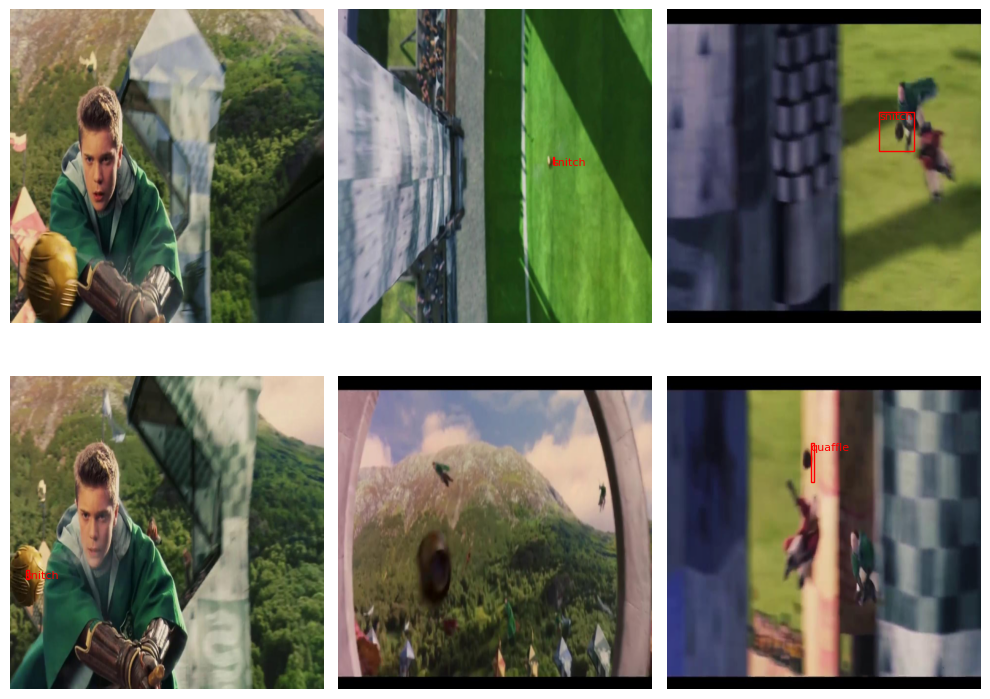

In [19]:
visualize(image, pred, train_ds.class_dict_inv)

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [20]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.4/660.4 kB 10.8 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [21]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [22]:
def annotation2txt(bboxes, w_im, h_im):
    ans = []
    for res in bboxes:
        xmin = res[0]
        ymin = res[1]
        xmax = res[2]
        ymax = res[3]
        item_class = res[4]

        c_x = (xmin + xmax) / 2
        c_y = (ymin + ymax) / 2
        c_n_x = c_x / w_im
        c_n_y = c_y / h_im

        w_box = (xmax - xmin) / 2
        h_box = (ymax - ymin) / 2
        w_n_box = w_box / w_im
        h_n_box = h_box / h_im

        new_res = [item_class, c_n_x, c_n_y, w_n_box, h_n_box]
        new_res = [str(x) for x in new_res]
        one_line = ' '.join(new_res)
        ans.append(one_line)
    return ans

In [23]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [24]:
# Собираем YAML

nc = 3 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names = ['snitch', 'quaffle', 'bludger'] # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [25]:
import ultralytics

model = ultralytics.YOLO("yolov8n.yaml")
a = model.train(data="data.yaml", epochs=10)  # train the model
# metrics = model.val()  # evaluate model performance on the validation set


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 14.5MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 67.1MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<00:00, 1199.31it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 596.11it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      5.21G      5.409      49.79       4.17         15        640: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.48G      5.019      38.63      3.923         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.47G      4.789      35.28      3.592         15        640: 100%|██████████| 16/16 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.47G      4.893       24.7      3.664         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.47G       3.97      17.08      3.449         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.49G      3.709      16.25      3.124         15        640: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.49G      3.729      14.16      2.666         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.49G      3.734      13.29      2.737         16        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.49G      3.546      12.97       2.45         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]

                   all         29         35          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.49G      3.477      12.77      2.479         13        640: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         29         35          0          0          0          0



10 epochs completed in 0.021 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         29         35          0          0          0          0


Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train


In [26]:
a = model.val()

Ultralytics YOLOv8.0.226 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/valid/labels.cache... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         29         35          0          0          0          0


Speed: 0.3ms preprocess, 14.9ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train2


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

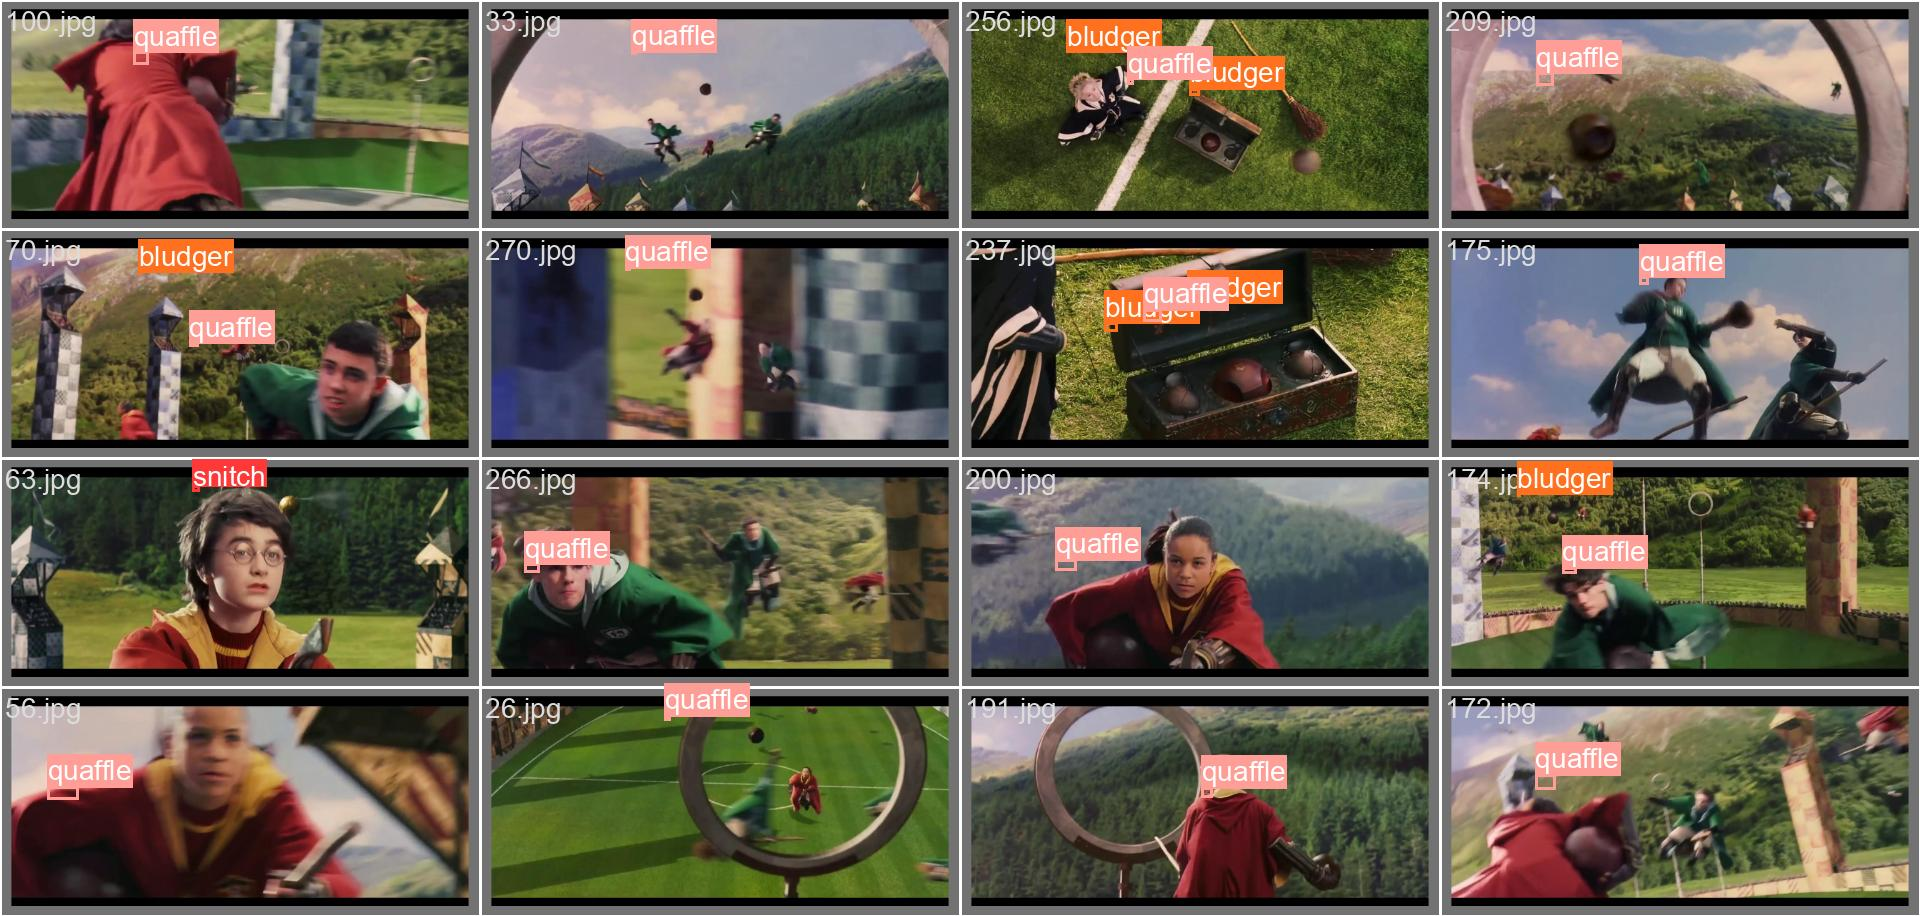